t_burn =  146.59620967741935
ΔV_Actual =  2.1930558509436233  km/s;
ΔV_Ideal =  3.648347562786369  km/s;
ΔV_Drag =  -0.032038493659444583  km/s;
ΔV_Gravity =  -1.4232532181833006  km/s;


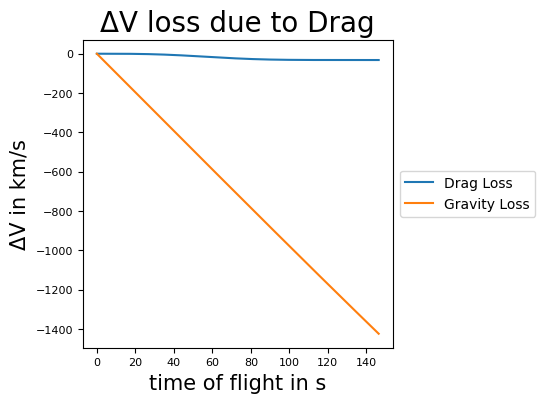

In [4]:
import numpy as np
import matplotlib.pyplot as plt

def runge_kutta_system(f, y0, t0, t_end, h):
    """
    Fourth-order Runge-Kutta method for solving a system of ODEs.
    
    Parameters:
        f: function representing the system of ODEs (dy/dt = f(t, y))
        y0: initial values of variables (as a list or numpy array)
        t0: initial value of t
        t_end: end value of t
        h: step size
        
    Returns:
        List of time values and numpy array of approximated y values for each variable at each time step.
    """
    t_values = []
    y_values = []
    t = t0
    y = np.array(y0)
    
    while t <= t_end:
        t_values.append(t)
        y_values.append(y)
        
        k1 = h * np.array(f(t, y))
        k2 = h * np.array(f(t + 0.5 * h, y + 0.5 * k1))
        k3 = h * np.array(f(t + 0.5 * h, y + 0.5 * k2))
        k4 = h * np.array(f(t + h, y + k3))
        
        y = y + (1/6) * (k1 + 2*k2 + 2*k3 + k4)
        t += h
    
    return t_values, np.array(y_values)

def standard_atmosphere(h):
    """
    Calculate standard atmosphere parameters at a given altitude.

    Parameters:
    - h: Altitude in meters.

    Returns:
    - T: Temperature in Kelvin.
    - P: Pressure in Pascals.
    - rho: Density in kg/m^3.
    """
    # Constants
    R = 287.05  # Specific gas constant for dry air in J/(kg·K)
    g0 = 9.80665  # Standard acceleration of gravity in m/s^2
    L = 0.0065  # Temperature lapse rate in K/m
    T0 = 288.15  # Standard sea level temperature in K
    P0 = 101325  # Standard sea level pressure in Pa
    rho0 = 1.225  # Standard sea level density in kg/m^3

    # Calculate temperature at altitude
    T = T0 - L * h

    # Calculate pressure at altitude
    P = P0 * (1 - L * h / T0) ** (g0 / (R * L))

    # Calculate density at altitude
    rho = rho0 * (1 - L * h / T0) ** ((g0 / (R * L)) - 1)

    return T, P, rho

def rocket_trajectory( t , y ):

#
# y[0] = v
# y[1] = gamma
# y[2] = h
# y[3] = s
#

    v     = y[0]
    gamma = y[1]
    h     = y[2]
    s     = y[3]

#
# m = m_0 - m_dot_e * t
#

    if t < t_0 + t_burn:
        m = m_0 - m_dot_e * t
    else:
        m = m_0 - m_dot_e * t_burn

#
# atmosphere model
#

    if i_atmosphere_model == 1:
        rho = rho_0 * np.exp( -h / h_s )
    elif i_atmosphere_model == 2:
        temp , press , rho = standard_atmosphere( h )

#
# aerodynamics
#
    
    L = 1. / 2. * rho * v**2 * np.pi * ( d / 2 )**2 * C_L
    L = 0.
    D = 1. / 2. * rho * v**2 * np.pi * ( d / 2 )**2 * C_D * np.sign( v )
    
#
# gravity
#

    g = g_0 / ( 1. + h / R_E )**2

#
# governing equations
#

    if t < t_0 + t_burn:
        dy_1_dt = T / m * np.cos( alpha ) - D / m  - g * np.sin( gamma )
    else:
        dy_1_dt = - D / m  - g * np.sin( gamma )
    
    dy_2_dt = 0.
    if v != 0:
        if t < t_0 + t_burn:
            dy_2_dt = 1 / v * ( T / m * np.sin( alpha ) + L / m - ( g + v**2 / ( R_E + h ) ) * np.cos( gamma ) )
        else:
            dy_2_dt = 1 / v * ( L / m - ( g + v**2 / ( R_E + h ) ) * np.cos( gamma ) )

    dy_3_dt = v * np.sin( gamma )

    dy_4_dt = ( R_E / ( R_E + h ) ) * v * np.cos( gamma )

    if t < t_0 + t_burn:
        dy_5_dt = T/m * np.cos(alpha)
    else:
        dy_5_dt = 0.
    
    dy_6_dt = - D / m

    dy_7_dt = - g * np.sin( gamma)

    return [ dy_1_dt , dy_2_dt , dy_3_dt , dy_4_dt , dy_5_dt, dy_6_dt, dy_7_dt]

# plotting & different initial conditions

def PlotStuff(ax,sim_vals, plot_labels,index,unit = "FEET"):
    title,Y_LABEL,X_LABEL,legend = plot_labels[0], plot_labels[1], plot_labels[2], plot_labels[3]
    # if DoNewPlot:
    # for sim_vals in sim_val_array:
    x_plot = sim_vals[0]
    y_plot = []
    if index == 2:
        if unit == "FEET":
            y_plot = (sim_vals[1][:, 2] - h_0) * 3.28 # 3.28 converts to feet
        if unit == "KILOMETERS":
            y_plot = (sim_vals[1][:, 2] - h_0) / 1000 # 
    elif index == 0:
        if unit == "FEET":
            y_plot = (sim_vals[1][:, 0]) * 3.28 # 3.28 converts to feet
        if unit == "KILOMETERS":
            y_plot = (sim_vals[1][:, 0]) /1000
    else:
        y_plot = sim_vals[1][:, index]


    ax.plot(x_plot,y_plot, label=legend)
    ax.set_title( title, fontsize=20.)
    ax.set_xlabel( X_LABEL, fontsize=15.)
    ax.set_ylabel( Y_LABEL, fontsize=15.)
    ax.tick_params(axis='x',labelsize= 8)
    ax.tick_params(axis='y',labelsize= 8)
    ax.legend( prop = {"size" : 8})
    ax.legend(loc='center left', bbox_to_anchor=(1, 0.5))

# constants

g_0 = 9.81
R_E = 6378000
h_s = 7500
rho_0 = 1.225

#
# Starship stage #1
#

C_L = 0
C_D = 1.3
i_atmosphere_model = 1
alpha = 0

m_0 = 5000000
d = 9
m_p = 3400000
T = 74400000
I_sp = 327

m_dot_e = T / (g_0 * I_sp)

t_burn = m_p / m_dot_e

print( 't_burn = ' , t_burn)

v_0 = 0
gamma_0 = 90 * np.pi / 180
h_0 = 0
s_0 = 0

t_0 = 0
t_f = t_burn
dt = (t_f - t_0) / 1000

y_0 = [v_0, gamma_0, h_0, s_0, 0., 0., 0.]
i_atmosphere_model = 1

vals_starship_stage1 = runge_kutta_system(rocket_trajectory, y_0, t_0, t_f, dt)

print( 'ΔV_Actual = ', vals_starship_stage1[1][-1, 0]/ 1000, ' km/s;')
print( 'ΔV_Ideal = ', vals_starship_stage1[1][-1, 4]/ 1000, ' km/s;')
print( 'ΔV_Drag = ', vals_starship_stage1[1][-1, 5]/ 1000, ' km/s;')
print( 'ΔV_Gravity = ', vals_starship_stage1[1][-1, 6]/ 1000, ' km/s;')

fig, ax = plt.subplots(figsize = (4,4))
labels = ["ΔV loss due to Drag","ΔV in km/s","time of flight in s","Drag Loss"]
# PlotStuff(ax,vals_starship_stage1,labels,4,"KILOMETERS")
PlotStuff(ax,vals_starship_stage1,labels,5,"KILOMETERS")
labels[3] = "Gravity Loss"
PlotStuff(ax,vals_starship_stage1,labels,6,"KILOMETERS")

In [ ]:



# second stage
m_0 = 1300000
d = 9
m_p = 1200000
T = 12300000
I_sp = 355

m_dot_e = T / (g_0 * I_sp)
t_burn = m_p / m_dot_e

# v_0 = vals_starship_stage1[1][-1,0]
# gamma_0 = vals_starship_stage1[1][-1,1]
# h_0 = vals_starship_stage1[1][-1,2]
# s_0 = vals_starship_stage1[1][-1,3]

y_0 = vals_starship_stage1[1][-1]
t_0 = vals_starship_stage1[0][-1]
t_f = t_0 + t_burn

vals_starship_stage2 = runge_kutta_system(rocket_trajectory, y_0, t_0, t_f, dt)
PlotStuff(vals_starship_stage2,"stage 2 altitude",2,"KILOMETERS")


# fig, ax = plt.subplots(figsize = (4,4))
# PlotStuff(vals_starship_stage1,"stage 1 v",0,"KILOMETERS")
# PlotStuff(vals_starship_stage2,"stage 2 v",0,"KILOMETERS")

# s1Q,s1M = GetQandMachNum(vals_starship_stage1)
# s2Q,s2M = GetQandMachNum(vals_starship_stage2)

# PlotStuff([vals_starship_stage1[0],[s1Q]],"stage 1 Q",0,"dynamic pressure")
# PlotStuff([vals_starship_stage1[0],s2Q],"stage 1 v",0,"KILOMETERS")